# Baseline and LSTM Model Only

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import importlib
import time
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

import src.util as util


# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [ ]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)



In [ ]:
# select only the first 50 time_id
subset_time_ids = snapshot_features_df['time_id'].unique()[:100]
subset_snapshop_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

In [47]:
importlib.reload(util)
#  Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(subset_snapshop_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

In [27]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def qlike_loss(y_true, y_pred):
    """
    QLIKE Loss: penalizes underestimation of volatility more than overestimation.
    """
    var_true = y_true ** 2
    var_pred = y_pred ** 2
    return np.mean(var_true / var_pred - np.log(var_true / var_pred) - 1)


def directional_accuracy(y_true, y_pred):
    """
    Computes directional accuracy: how often the direction (up/down) was predicted correctly.
    """
    actual_change = np.diff(y_true)
    predicted_change = np.diff(y_pred)
    return np.mean((actual_change * predicted_change) > 0)


def plot_prediction_vs_actual(df: pd.DataFrame, time_id: int,
                               y_true_col: str = "y_true", y_pred_col: str = "y_pred"):
    """
    Plot predicted vs. actual realized volatility over time for a given time_id.
    """
    df_plot = df[df["time_id"] == time_id]
    if df_plot.empty:
        print(f"[Warning] No data for time_id={time_id}")
        return

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["start_time"], df_plot[y_true_col], label="Actual", linewidth=2)
    plt.plot(df_plot["start_time"], df_plot[y_pred_col],
             label="Predicted", linestyle="--", linewidth=2)
    plt.title(f"LSTM Prediction vs Actual (time_id={time_id})")
    plt.xlabel("Seconds in Bucket")
    plt.ylabel("Realized Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_training_loss(history):
    """
    Plot training and validation loss over epochs.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("LSTM Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_inference_time_boxplot(val_df: pd.DataFrame, inference_col: str = 'inference_time'):
    """
    Plot a boxplot of inference time per rolling window during validation.
    """
    if inference_col not in val_df:
        print(f"[Warning] Column '{inference_col}' not found in DataFrame.")
        return
    times = val_df[inference_col].dropna()
    plt.figure(figsize=(8, 6))
    plt.boxplot(times, vert=True, showfliers=True)
    plt.title("Validation Inference Time per Window")
    plt.ylabel("Time (seconds)")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


=== HAR-RV OLS Baseline Evaluation ===
MSE: 0.00000003
RMSE: 0.00017762
QLIKE: 0.5682
Directional Accuracy: 0.5111
Average inference time per sample: 0.000030 seconds
✅ Model saved to out/harrv/har_ols.pkl


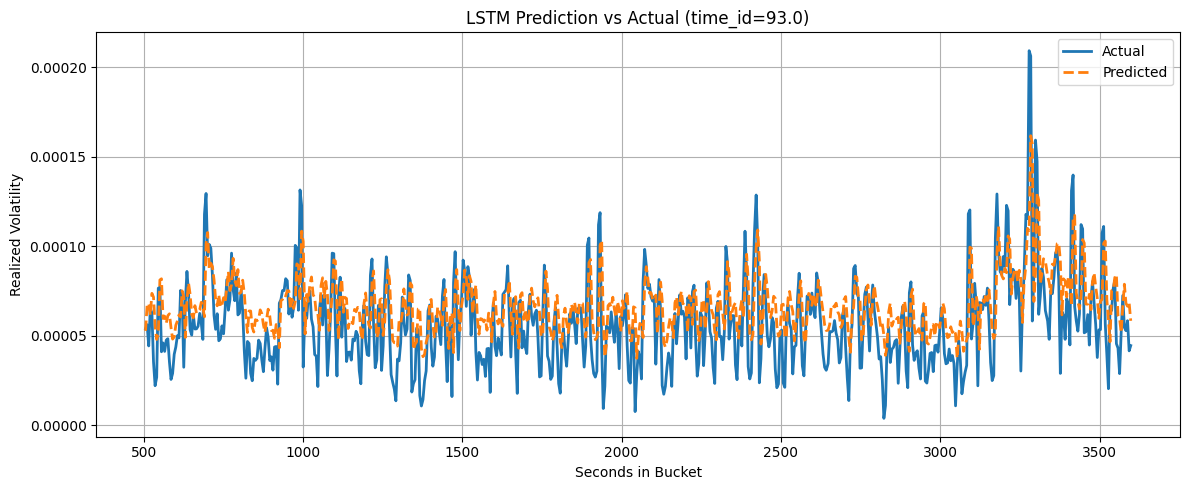

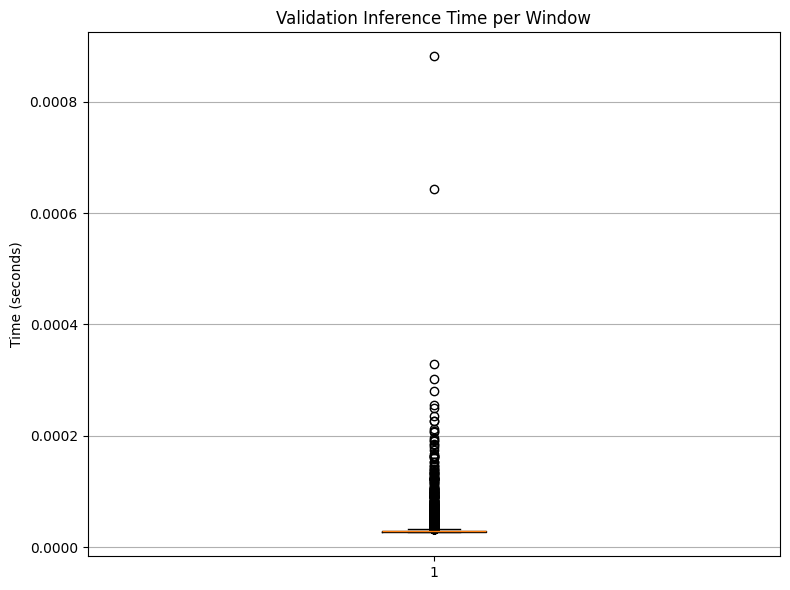

In [48]:
# OLS Model

# Import and reload HAR-RV model
# import function from models/har_rv.py
import src.har_rv as har_rv
importlib.reload(har_rv)

model_rv_ols, test_df_ols = har_rv.ols(rolling_features_df)

# Plot predicted vs. actual volatility for one time_id
plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

plot_inference_time_boxplot(test_df_ols)

In [ ]:
def lstm_baseline(snapshot_df: pd.DataFrame,
                  basic_features: list = ['wap', 'log_return'],
                  epochs: int = 50,
                  batch_size: int = 32,
                  learning_rate: float = 1e-4,
                  es_patience: int = 10,
                  lr_patience: int = 5,
                  model_name: str = 'baseline'
                 ):
    """
    Train a simple LSTM baseline using basic features.
    Uses an 80%/20% train/validation split based on time_id.
    Includes EarlyStopping and ReduceLROnPlateau callbacks.
    During validation, records inference time per window.
    Saves model to out/lstm/{model_name}.h5 and scalers to out/lstm/{model_name}_scalers.pkl.
    Returns trained model, history, and validation DataFrame with 'inference_time'.
    """
    # Feature engineering
    seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)

    X = np.stack(seq_df['X'].values)
    y = seq_df['y'].values
    time_ids = seq_df['time_id'].values
    starts = seq_df['start_time'].values

    # 80/20 time_id split
    unique_ids = np.sort(np.unique(time_ids))
    split_idx = int(len(unique_ids) * 0.8)
    train_ids, val_ids = unique_ids[:split_idx], unique_ids[split_idx:]
    mask_train = np.isin(time_ids, train_ids)
    mask_val = np.isin(time_ids, val_ids)

    X_train, X_val = X[mask_train], X[mask_val]
    y_train, y_val = y[mask_train], y[mask_val]
    val_ids_out = time_ids[mask_val]
    val_starts_out = starts[mask_val]

    # Scale inputs & targets
    x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_s = x_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_s = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
    y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()

    # Build model
    model = Sequential([Input(shape=X_train_s.shape[1:]), LSTM(64), Dense(1)])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=lr_patience, min_lr=1e-6)
    ]

    # Train
    history = model.fit(X_train_s, y_train_s,
                        validation_data=(X_val_s, y_val_s := y_scaler.transform(y_val.reshape(-1,1)).ravel()),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks, verbose=1)

    # Validation inference with timing
    inference_times = []
    y_pred_s = []
    for sample in X_val_s:
        start_t = time.perf_counter()
        pred = model.predict(sample[np.newaxis, ...], verbose=0).ravel()[0]
        inference_times.append(time.perf_counter() - start_t)
        y_pred_s.append(pred)
    y_pred_s = np.array(y_pred_s)
    y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

    # Prepare validation DataFrame
    val_df = pd.DataFrame({
        'time_id': val_ids_out,
        'start_time': val_starts_out,
        'y_true': y_val,
        'y_pred': y_pred,
        'inference_time': inference_times
    })

    # Metrics
    mse = np.mean((y_val - y_pred)**2)
    avg_time = np.mean(inference_times)
    print(f"Validation MSE: {mse:.8f}")
    print(f"Validation RMSE: {np.sqrt(mse):.8f}")
    print(f"Validation QLIKE: {qlike_loss(y_val, y_pred):.4f}")
    print(f"Directional Acc: {directional_accuracy(y_val, y_pred):.4f}")
    print(f"Average inference time per window: {avg_time:.6f} seconds")

    # Save model & scalers
    out_dir = 'out/lstm'
    os.makedirs(out_dir, exist_ok=True)
    model.save(os.path.join(out_dir, f'{model_name}.h5'), save_format='tf')
    with open(os.path.join(out_dir, f'{model_name}_scalers.pkl'), 'wb') as f:
        pickle.dump({'x_scaler': x_scaler, 'y_scaler': y_scaler}, f)
    print(f"Model & scalers saved to {out_dir}")

    return model, history, val_df



In [29]:
# --- Run LSTM Baseline ---
model_baseline, history_baseline, val_df_baseline = lstm_baseline(
    snapshot_df=subset_snapshop_df,
    basic_features=['wap', 'log_return'],
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='baseline'
)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.7464 - val_loss: 0.8000 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5570 - val_loss: 0.7958 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - loss: 0.5499 - val_loss: 0.7930 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5468 - val_loss: 0.7874 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5443 - val_loss: 0.7824 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5419 - val_loss: 0.7774 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5398 - val_loss: 0.7729 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5383 - val_loss: 0.7700 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00005932
Validation QLIKE: 0.3547
Directional Acc: 0.3362
Average inference time per window: 0.031662 seconds
Model & scalers saved to out/lstm


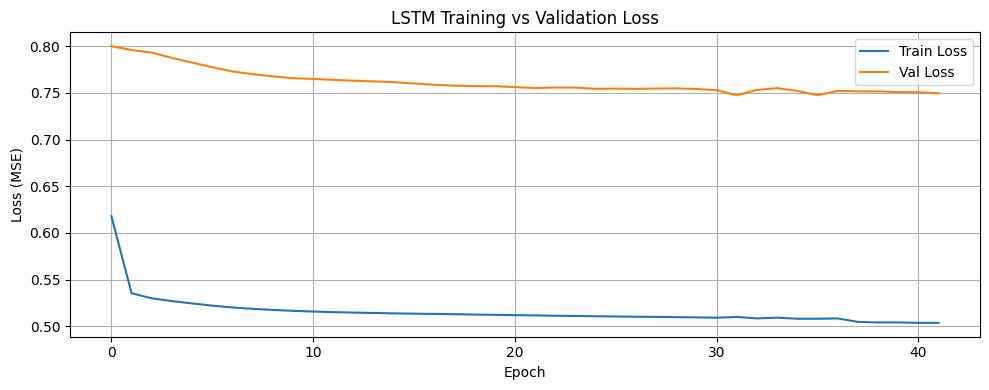

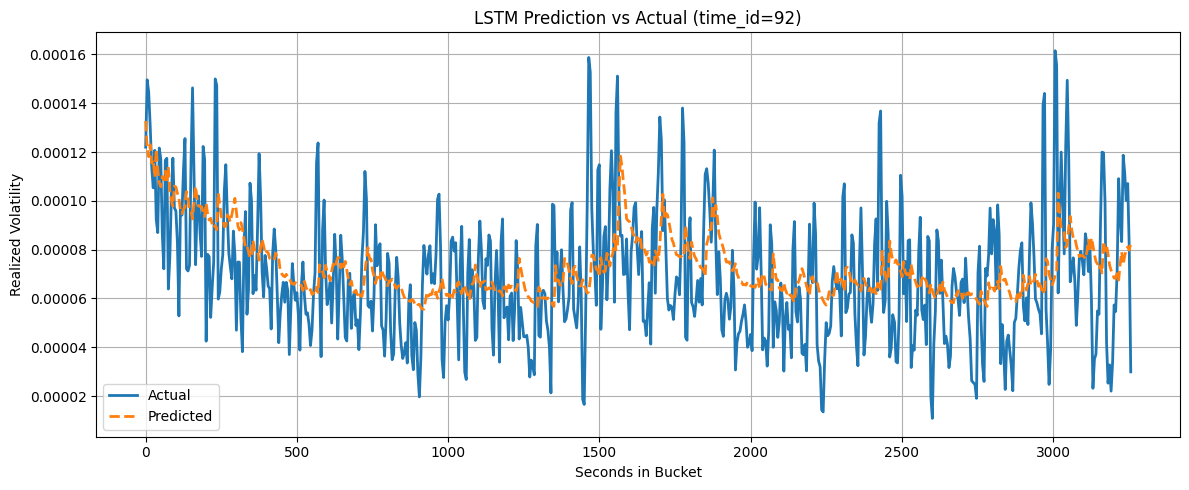

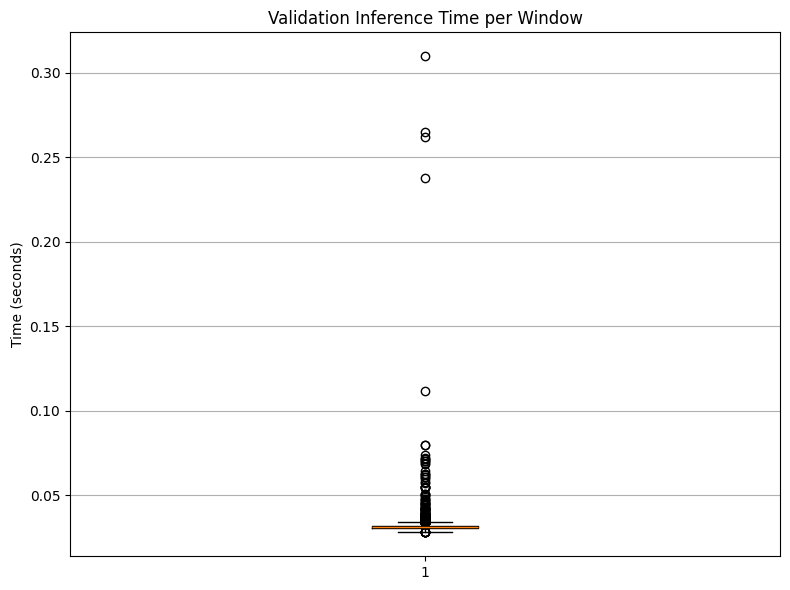

In [30]:
# --- Plot training loss ---
plot_training_loss(history_baseline)

# --- Plot prediction vs actual ---
plot_prediction_vs_actual(
    val_df_baseline,
    time_id=val_df_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

plot_inference_time_boxplot(val_df_baseline)

In [31]:
# import os
# import pickle
# import numpy as np
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# import keras_tuner as kt

# def hyperparameter_tuning_experiment(snapshot_df: pd.DataFrame,
#                                      basic_features: list = ['wap', 'log_return'],
#                                      max_trials: int = 20,
#                                      epochs: int = 50,
#                                      batch_size: int = 32,
#                                      learning_rate: float = 1e-4,
#                                      es_patience: int = 10):
#     """
#     Run KerasTuner RandomSearch to find best hyperparameters.
#     Uses entire provided snapshot_df (assumed pre-truncated) for tuning.
#     Prints best hyperparameters only.
#     """
#     # Prepare data
#     seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)

#     X = np.stack(seq_df['X'].values)
#     y = seq_df['y'].values
#     time_ids = seq_df['time_id'].values
#     unique_ids = np.sort(np.unique(time_ids))
#     split_idx = int(len(unique_ids) * 0.8)
#     train_ids, val_ids = unique_ids[:split_idx], unique_ids[split_idx:]
#     mask_train = np.isin(time_ids, train_ids)
#     mask_val = np.isin(time_ids, val_ids)
#     X_train, X_val = X[mask_train], X[mask_val]
#     y_train, y_val = y[mask_train], y[mask_val]

#     # Scale
#     x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
#     X_train_s = x_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#     X_val_s = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
#     y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
#     y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()
#     y_val_s = y_scaler.transform(y_val.reshape(-1,1)).ravel()

#     # Hypermodel builder
#     def build_model(hp):
#         model = Sequential()
#         model.add(Input(shape=X_train_s.shape[1:]))
#         num_layers = hp.Int('num_layers', 1, 2)
#         for i in range(num_layers):
#             units = hp.Choice(f'units_{i}', [32, 64, 128])
#             return_seq = True if i < num_layers - 1 else False
#             model.add(LSTM(units, return_sequences=return_seq))
#             dropout_rate = hp.Choice(f'dropout_{i}', [0.1, 0.2, 0.3])
#             model.add(Dropout(dropout_rate))
#         model.add(Dense(1))
#         lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
#         model.compile(optimizer=Adam(lr), loss='mse')
#         return model

#     tuner = kt.RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=max_trials,
#         executions_per_trial=1,
#         directory='models/out/lstm/tuner',
#         project_name='lstm_tuning'
#     )

#     tuner.search(
#         X_train_s, y_train_s,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(X_val_s, y_val_s),
#         callbacks=[EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True)]
#     )

#     best_hp = tuner.get_best_hyperparameters()[0]
#     print("Best hyperparameters:")
#     for key, val in best_hp.values.items():
#         print(f"  {key}: {val}")
#     return best_hp


# best_hp = hyperparameter_tuning_experiment(
#     snapshot_df=subset_snapshop_df,
#     basic_features=['wap', 'log_return'],
#     max_trials=20,
#     epochs=50,
#     batch_size=32,
#     learning_rate=1e-4,
#     es_patience=10
# )

The experiment for baseline returns:

```out
Trial 20 Complete [00h 33m 23s]
val_loss: 0.2789573669433594

Best val_loss So Far: 0.2738760709762573
Total elapsed time: 10h 36m 24s
Best hyperparameters:
  num_layers: 1
  units_0: 64
  dropout_0: 0.1
  learning_rate: 0.0001
  units_1: 128
  dropout_1: 0.1
```

In [32]:
model_final_baseline, history_final_baseline, val_df_final_baseline = lstm_baseline(
    subset_snapshop_df,
    basic_features=['wap','log_return'],
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='final_baseline'
)


Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.7917 - val_loss: 0.7830 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5622 - val_loss: 0.7711 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5525 - val_loss: 0.7657 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5478 - val_loss: 0.7584 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5441 - val_loss: 0.7543 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5413 - val_loss: 0.7532 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5392 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - loss: 0.5376 - val_loss: 0.7526 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00005870
Validation QLIKE: 0.3626
Directional Acc: 0.3380
Average inference time per window: 0.030098 seconds
Model & scalers saved to out/lstm


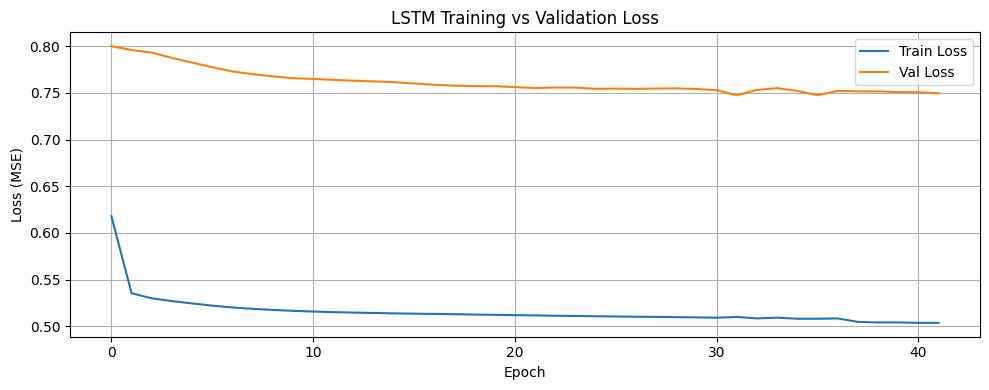

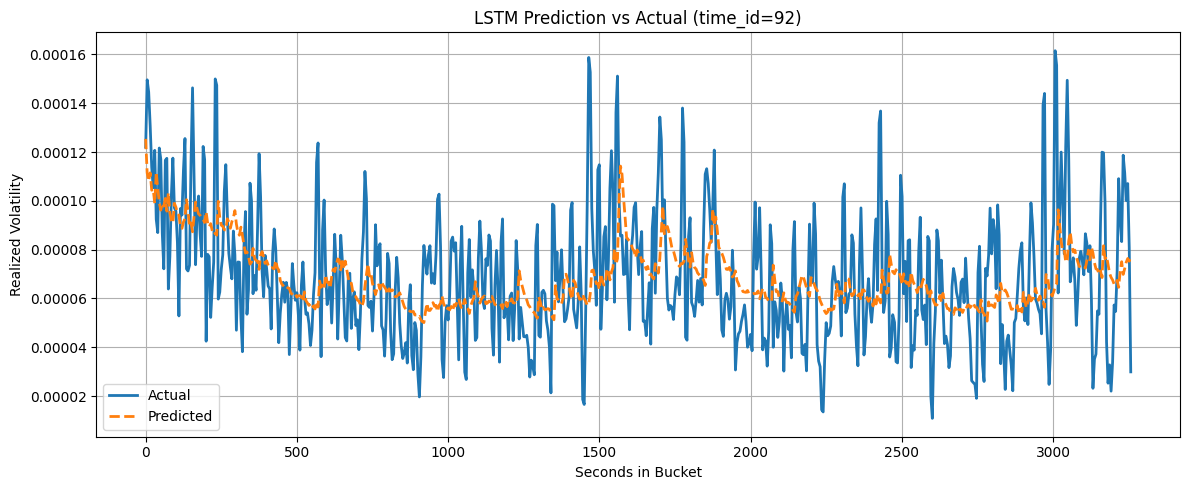

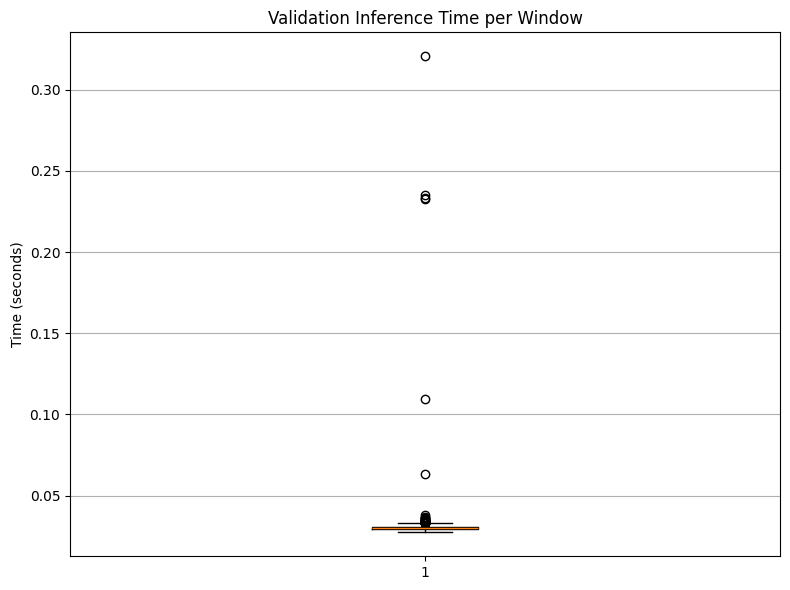

In [33]:
# --- Plot training loss ---
plot_training_loss(history_baseline)

# --- Plot prediction vs actual ---
plot_prediction_vs_actual(
    val_df_final_baseline,
    time_id=val_df_final_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

plot_inference_time_boxplot(val_df_final_baseline)

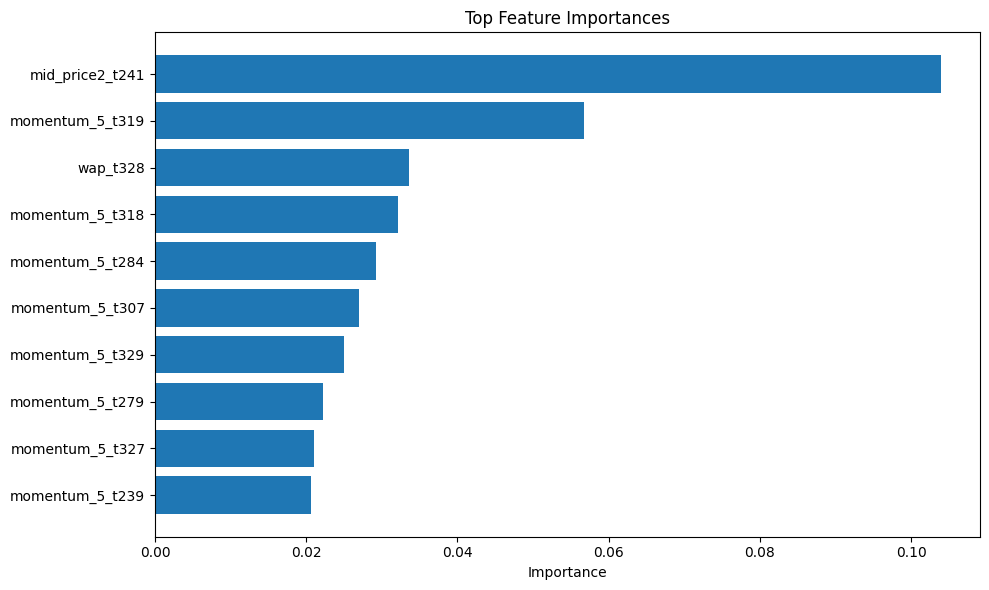

In [34]:
import os
import pickle
import time
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import keras_tuner as kt

# --- Feature Groups for Incremental Experiments ---
FEATURE_GROUPS = {
    'baseline': ['wap', 'log_return'],
    'level_snapshot': [
        'wap', 'spread_pct', 'imbalance', 'depth_ratio',
        'mid_price2', 'wap2', 'spread2_pct', 'imbalance2', 'depth_ratio2'
    ],
    'microstructure': [
        'micro_price', 'slope_ask', 'slope_bid', 'cum_depth_imbalance', 'spread_slope'
    ],
    'momentum': [
        'momentum_5'
    ],
    'order_flow': [
        'delta_bid1', 'delta_ask1', 'delta_bid2', 'delta_ask2'
    ],
    'time_encoding': [
        'sin_time', 'cos_time'
    ]
}


def feature_importance(snapshot_df: pd.DataFrame, basic_features: list = None,
                       model_type: str = 'rf', top_n: int = 10):
    """
    Compute feature importance using RandomForest or XGBoost.
    Returns a sorted list of (feature, importance).
    """
    # gather all engineered columns
    if basic_features is None:
        basic_features = []
        for group in FEATURE_GROUPS.values():
            basic_features += group
    # generate sequences
    seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)
    # Flatten X into DataFrame
    X = np.stack(seq_df['X'].values)
    n_samples, window, n_feats = X.shape
    X_flat = X.reshape(n_samples, window * n_feats)
    feature_names = []
    for i in range(window):
        for feat in basic_features:
            feature_names.append(f"{feat}_t{i}")
    y = seq_df['y'].values
    # Fit model
    if model_type == 'xgb':
        model = XGBRegressor(objective='reg:squarederror', n_jobs=-1)
    else:
        model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    model.fit(X_flat, y)
    # Extract importances
    importances = model.feature_importances_
    feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    return feat_imp[:top_n]


def plot_feature_importance(feat_imp: list):
    """
    Plot bar chart of feature importances.
    Expects list of (feature, importance).
    """
    names, imps = zip(*feat_imp)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(names))[::-1], imps, align='center')
    plt.yticks(range(len(names))[::-1], names)
    plt.xlabel('Importance')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()


features = [
        # Level 1 & 2
        'wap', 'spread_pct', 'imbalance', 'depth_ratio',
        'mid_price2', 'wap2', 'spread2_pct', 'imbalance2', 'depth_ratio2',
        # Microstructure
        'micro_price', 'slope_ask', 'slope_bid', 'cum_depth_imbalance', 'spread_slope',
        # Momentum & returns
        'log_return', 'momentum_5', 'mid_return',
        # Time encoding
        'sin_time', 'cos_time',
        # Order-flow deltas
        'delta_bid1', 'delta_ask1', 'delta_bid2', 'delta_ask2'
    ]

top_feats = feature_importance(subset_snapshop_df, features, model_type='xgb')
plot_feature_importance(top_feats)

In [35]:
# momentum
model_momentum, hist_momentum, df_momentum = lstm_baseline(subset_snapshop_df, basic_features=FEATURE_GROUPS['baseline'] + FEATURE_GROUPS['momentum'], model_name='exp_momentum')


Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.7644 - val_loss: 0.9132 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5652 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5510 - val_loss: 0.8197 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5453 - val_loss: 0.7995 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5416 - val_loss: 0.7908 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5388 - val_loss: 0.7819 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5367 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - loss: 0.5350 - val_loss: 0.7783 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00005947
Validation QLIKE: 0.3559
Directional Acc: 0.3393
Average inference time per window: 0.032726 seconds
Model & scalers saved to out/lstm


In [36]:
# level_snapshot
model_snapshot, hist_snapshot, df_snapshot = lstm_baseline(subset_snapshop_df, basic_features=FEATURE_GROUPS['baseline'] + FEATURE_GROUPS['level_snapshot'], model_name='exp_snapshot')


Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.7963 - val_loss: 0.9326 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5715 - val_loss: 0.8470 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5577 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.5513 - val_loss: 0.8226 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - loss: 0.5468 - val_loss: 0.8185 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 0.5433 - val_loss: 0.8149 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step - loss: 0.5405 - val_loss: 0.8121 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.5383 - val_loss: 0.8094 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00006021
Validation QLIKE: 0.3815
Directional Acc: 0.3727
Average inference time per window: 0.030715 seconds
Model & scalers saved to out/lstm


In [37]:
# both
model_both, hist_both, df_both = lstm_baseline(subset_snapshop_df, basic_features=FEATURE_GROUPS['baseline'] + FEATURE_GROUPS['level_snapshot'] + FEATURE_GROUPS['momentum'], model_name='exp_both')

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.7931 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5721 - val_loss: 0.8886 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5543 - val_loss: 0.8688 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5471 - val_loss: 0.8513 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5431 - val_loss: 0.8390 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5404 - val_loss: 0.8303 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5384 - val_loss: 0.8242 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5366 - val_loss: 0.8191 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00006108
Validation QLIKE: 0.3883
Directional Acc: 0.3666
Average inference time per window: 0.032128 seconds
Model & scalers saved to out/lstm


In [38]:
# mid_price
model_mid_price, hist_mid_price, df_mid_price = lstm_baseline(subset_snapshop_df, basic_features=FEATURE_GROUPS['baseline'] + ['mid_price2'], model_name='exp_mid_price')

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.8238 - val_loss: 0.8287 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5588 - val_loss: 0.8211 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5507 - val_loss: 0.8108 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5461 - val_loss: 0.8007 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.5431 - val_loss: 0.7942 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.5408 - val_loss: 0.7927 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.5391 - val_loss: 0.7891 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.5377 - val_loss: 0.7848 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step 

Validation MSE: 0.00000000
Validation RMSE: 0.00005916
Validation QLIKE: 0.3568
Directional Acc: 0.3331
Average inference time per window: 0.030354 seconds
Model & scalers saved to out/lstm


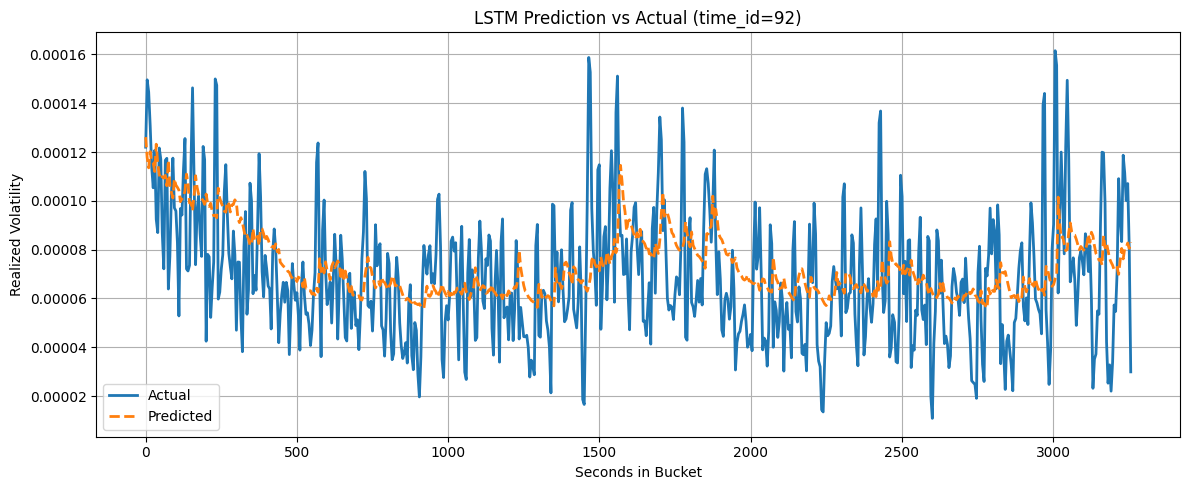

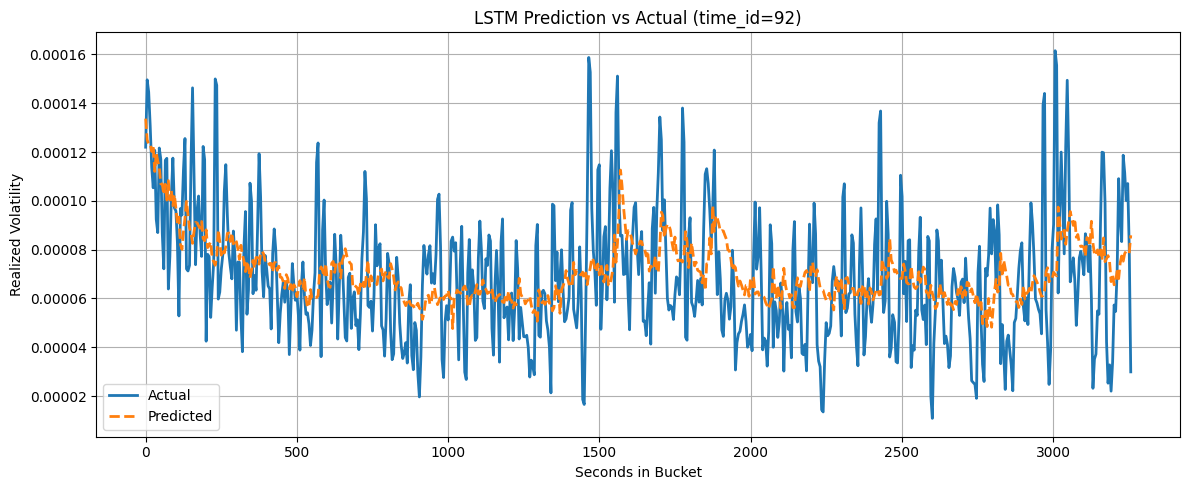

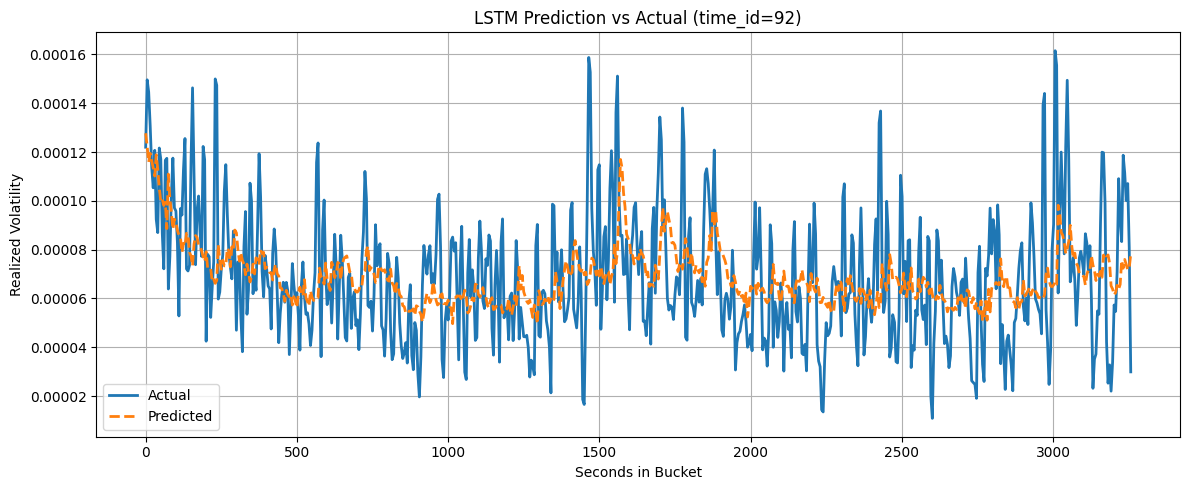

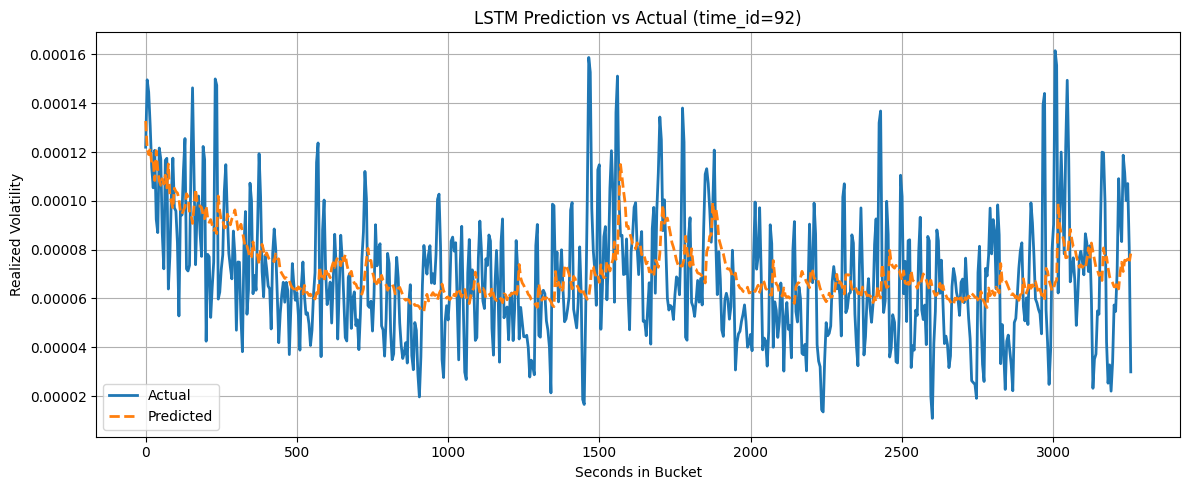

In [39]:
# --- Plot prediction vs actual ---
plot_prediction_vs_actual(
    df_momentum,
    time_id=df_momentum['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

plot_prediction_vs_actual(
    df_snapshot,
    time_id=df_snapshot['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

plot_prediction_vs_actual(
    df_both,
    time_id=df_both['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

plot_prediction_vs_actual(
    df_mid_price,
    time_id=df_mid_price['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)


In [51]:
def lstm_advanced(snapshot_df: pd.DataFrame,
                  basic_features: list = FEATURE_GROUPS['baseline'],
                  epochs: int = 50,
                  batch_size: int = 32,
                  learning_rate: float = 1e-4,
                  es_patience: int = 10,
                  lr_patience: int = 5,
                  model_name: str = 'lstm_advanced'
                 ):
    """
    Train a deeper, bi-directional LSTM with Dropout and Dense layers.
    Uses 80/20 split on time_id. Measures inference time and saves model.
    """
    # Feature engineering
    seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)

    X = np.stack(seq_df['X'].values)
    y = seq_df['y'].values
    time_ids = seq_df['time_id'].values
    starts = seq_df['start_time'].values

    # Split
    unique_ids = np.sort(np.unique(time_ids))
    split_idx = int(len(unique_ids) * 0.8)
    train_ids, val_ids = unique_ids[:split_idx], unique_ids[split_idx:]
    mask_train = np.isin(time_ids, train_ids)
    mask_val = np.isin(time_ids, val_ids)

    X_train, X_val = X[mask_train], X[mask_val]
    y_train, y_val = y[mask_train], y[mask_val]
    val_ids_out = time_ids[mask_val]
    val_starts_out = starts[mask_val]

    # Scale
    x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_s = x_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_s = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
    y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()

    # Build advanced model
    from tensorflow.keras.layers import Bidirectional
    model = Sequential([
        Input(shape=X_train_s.shape[1:]),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=lr_patience, min_lr=1e-6)
    ]

    # Train
    history = model.fit(
        X_train_s, y_train_s,
        validation_data=(X_val_s, y_val_s := y_scaler.transform(y_val.reshape(-1,1)).ravel()),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )

    # Inference timing
    inference_times, preds = [], []
    for sample in X_val_s:
        t0 = time.perf_counter()
        p = model.predict(sample[np.newaxis,...], verbose=0).ravel()[0]
        inference_times.append(time.perf_counter() - t0)
        preds.append(p)
    y_pred = y_scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()

    # Prepare val_df
    val_df = pd.DataFrame({
        'time_id': val_ids_out,
        'start_time': val_starts_out,
        'y_true': y_val,
        'y_pred': y_pred,
        'inference_time': inference_times
    })

    # Metrics
    mse = np.mean((y_val - y_pred)**2)
    avg_time = np.mean(inference_times)
    print(f"Validation MSE: {mse:.8f}")
    print(f"Validation RMSE: {np.sqrt(mse):.8f}")
    print(f"Validation QLIKE: {qlike_loss(y_val, y_pred):.4f}")
    print(f"Directional Acc: {directional_accuracy(y_val, y_pred):.4f}")
    print(f"Average inference time per window: {avg_time:.6f} seconds")

    # Save
    out_dir = 'out/lstm'
    os.makedirs(out_dir, exist_ok=True)
    model.save(os.path.join(out_dir, f'{model_name}.h5'), save_format='tf')
    with open(os.path.join(out_dir, f'{model_name}_scalers.pkl'), 'wb') as f:
        pickle.dump({'x_scaler': x_scaler, 'y_scaler': y_scaler}, f)
    print(f"Advanced model & scalers saved to {out_dir}")

    return model, history, val_df

In [52]:
model_adv, hist_adv, df_adv = lstm_advanced(
    subset_snapshop_df,
    basic_features=FEATURE_GROUPS['baseline'] + FEATURE_GROUPS['level_snapshot'] + FEATURE_GROUPS['momentum'],
    epochs=50,
    batch_size=32,
    model_name='exp_advanced'
)



KeyboardInterrupt: 

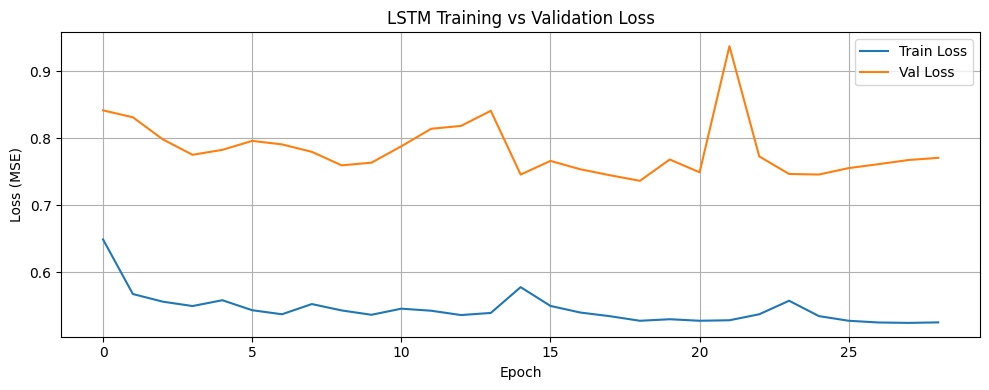

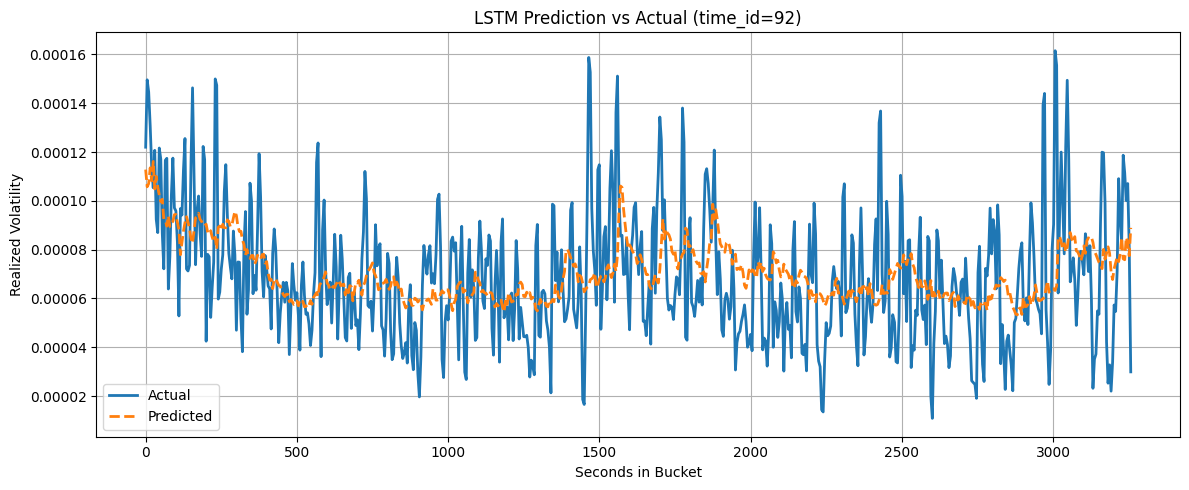

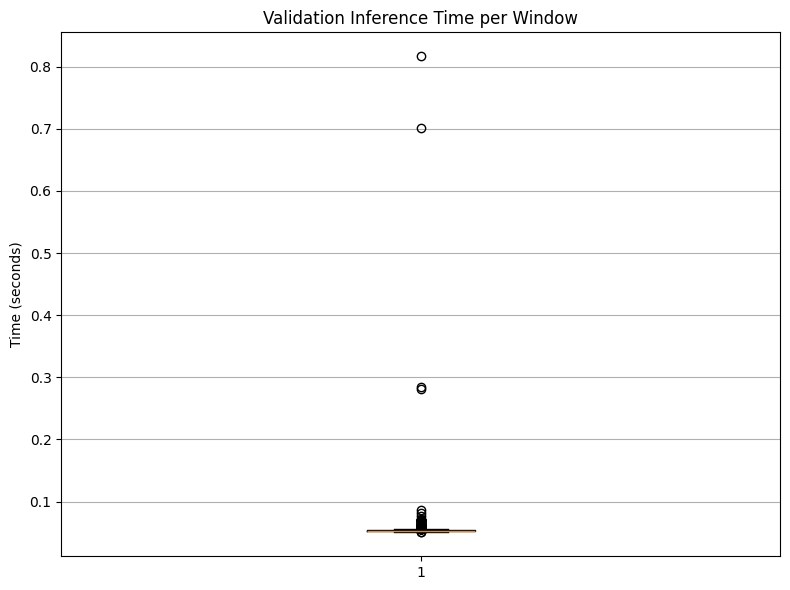

In [ ]:
plot_training_loss(hist_adv)
plot_prediction_vs_actual(
    df_adv,
    time_id=df_adv['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)
plot_inference_time_boxplot(df_adv)

In [56]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Dropout, Bidirectional, LSTM,
    Attention, GlobalAveragePooling1D, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler


def lstm_final_test(snapshot_df: pd.DataFrame,
                    basic_features: list,
                    epochs: int = 50,
                    batch_size: int = 32,
                    learning_rate: float = 1e-4,
                    es_patience: int = 10,
                    lr_patience: int = 5,
                    model_name: str = 'lstm_small'):

    # 特征处理
    seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)

    X = np.stack(seq_df['X'].values)
    y = seq_df['y'].values
    time_ids = seq_df['time_id'].values
    starts = seq_df['start_time'].values

    # 80/20 时间 ID 划分
    unique_ids = np.sort(np.unique(time_ids))
    split = int(len(unique_ids) * 0.8)
    train_ids, val_ids = unique_ids[:split], unique_ids[split:]
    mask_train = np.isin(time_ids, train_ids)
    mask_val = np.isin(time_ids, val_ids)
    X_train, X_val = X[mask_train], X[mask_val]
    y_train, y_val = y[mask_train], y[mask_val]
    val_ids_out = time_ids[mask_val]
    val_starts_out = starts[mask_val]

    # 标准化
    x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_s = x_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_s = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
    y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()

    # 构建简化模型
    model = Sequential([
        Input(shape=X_train_s.shape[1:]),
        Conv1D(16, 3, padding='same', activation='relu'),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=lr_patience, min_lr=1e-6)
    ]

    # 训练
    history = model.fit(
        X_train_s, y_train_s,
        validation_data=(X_val_s, y_scaler.transform(y_val.reshape(-1,1)).ravel()),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )

    # 验证推理计时
    times, preds = [], []
    for seq in X_val_s:
        t0 = time.perf_counter()
        p = model.predict(seq[np.newaxis,...], verbose=0).ravel()[0]
        times.append(time.perf_counter() - t0)
        preds.append(p)
    preds = np.array(preds)
    y_pred = y_scaler.inverse_transform(preds.reshape(-1,1)).ravel()

    # 构建结果 DataFrame
    val_df = pd.DataFrame({
        'time_id': val_ids_out,
        'start_time': val_starts_out,
        'y_true': y_val,
        'y_pred': y_pred,
        'inference_time': times
    })

    # 评估
    mse = np.mean((y_val - y_pred)**2)
    print(f"Small Test MSE: {mse:.8f}")
    print(f"Small Test RMSE: {np.sqrt(mse):.8f}")
    print(f"Small Test QLIKE: {qlike_loss(y_val, y_pred):.4f}")
    print(f"Small Test Dir Acc: {directional_accuracy(y_val, y_pred):.4f}")
    print(f"Avg Inf Time: {np.mean(times):.6f}s")

    # 保存
    out = 'out/lstm'
    os.makedirs(out, exist_ok=True)
    model.save(os.path.join(out, f'{model_name}.keras'))
    with open(os.path.join(out, f'{model_name}_scalers.pkl'), 'wb') as f:
        pickle.dump({'x_scaler': x_scaler, 'y_scaler': y_scaler}, f)
    print(f"Small test model saved to {out}")

    return model, history, val_df


def lstm_final(snapshot_df: pd.DataFrame,
               basic_features: list,
               epochs: int = 100,
               batch_size: int = 64,
               learning_rate: float = 1e-4,
               es_patience: int = 15,
               lr_patience: int = 7,
               model_name: str = 'lstm_final'):
    """
    final LSTM-based volatility forecaster:
      - 1D-CNN layers for local pattern extraction
      - BiLSTM layers stacked for long/short-term memory
      - Self-attention to focus on key timesteps
      - Global pooling + Dense head
      - Custom QLIKE loss option
    """
    # feature engineering
    seq_df = util.generate_tick_sequences(snapshot_df, feature_cols=basic_features)

    X = np.stack(seq_df['X'].values)
    y = seq_df['y'].values
    time_ids = seq_df['time_id'].values
    starts = seq_df['start_time'].values

    # 80/20 split by time_id
    unique_ids = np.sort(np.unique(time_ids))
    split = int(len(unique_ids) * 0.8)
    train_ids, val_ids = unique_ids[:split], unique_ids[split:]
    mask_train = np.isin(time_ids, train_ids)
    mask_val = np.isin(time_ids, val_ids)
    X_train, X_val = X[mask_train], X[mask_val]
    y_train, y_val = y[mask_train], y[mask_val]
    val_ids_out = time_ids[mask_val]
    val_starts_out = starts[mask_val]

    # scaling
    x_scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_s = x_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_s = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train_s = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
    y_val_s = y_scaler.transform(y_val.reshape(-1, 1)).ravel()

    # build model
    W, D = X_train_s.shape[1], X_train_s.shape[2]
    inp = Input(shape=(W, D))
    x = Conv1D(32, 3, padding='same', activation='relu')(inp)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    # self-attention
    attn_out = Attention()([x, x])
    # pool & head
    x = GlobalAveragePooling1D()(attn_out)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)

    # compile with QLIKE
    model.compile(
        optimizer=Adam(learning_rate),
        loss='mse',  # or use qlike_loss_tf
        metrics=[]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=lr_patience, min_lr=1e-6)
    ]

    # train
    history = model.fit(
        X_train_s, y_train_s,
        validation_data=(X_val_s, y_val_s),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # inference timing
    times, preds = [], []
    for s in X_val_s:
        t0 = time.perf_counter()
        p = model.predict(s[np.newaxis, ...], verbose=0).ravel()[0]
        times.append(time.perf_counter() - t0)
        preds.append(p)
    preds = np.array(preds)
    y_pred = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()

    val_df = pd.DataFrame({
        'time_id': val_ids_out,
        'start_time': val_starts_out,
        'y_true': y_val,
        'y_pred': y_pred,
        'inference_time': times
    })

    # evaluation
    mse = np.mean((y_val - y_pred) ** 2)
    print(f"Final Model MSE: {mse:.8f}")
    print(f"Final Model RMSE: {np.sqrt(mse):.8f}")
    print(f"Final Model QLIKE: {qlike_loss(y_val, y_pred):.4f}")
    print(f"Directional Acc: {directional_accuracy(y_val, y_pred):.4f}")
    print(f"Avg Inference Time: {np.mean(times):.6f}s")

    # save
    out_dir = 'out/lstm'
    os.makedirs(out_dir, exist_ok=True)
    model.save(os.path.join(out_dir, f'{model_name}.h5'), save_format='tf')
    with open(os.path.join(out_dir, f'{model_name}_scalers.pkl'), 'wb') as f:
        pickle.dump({'x_scaler': x_scaler, 'y_scaler': y_scaler}, f)
    print(f"Saved final model & scalers to {out}")

    return model, history, val_df


In [57]:
model_final_test, hist_final_test, df_final_test = lstm_final_test(
    subset_snapshop_df,
    basic_features=FEATURE_GROUPS['baseline'] + FEATURE_GROUPS['level_snapshot'] + FEATURE_GROUPS['momentum'],
    epochs=50,
    batch_size=32,
    model_name='final_test'
)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 250s 151ms/step - loss: 0.7604 - val_loss: 0.8038 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 244s 150ms/step - loss: 0.5733 - val_loss: 0.7925 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 244s 150ms/step - loss: 0.5609 - val_loss: 0.8026 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 248s 152ms/step - loss: 0.5538 - val_loss: 0.7741 - learning_rate: 1.0000e-04
Epoch 5/50
1609/1629 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.5517

KeyboardInterrupt: 

In [ ]:
plot_training_loss(hist_final_test)
plot_prediction_vs_actual(
    df_final_test,
    time_id=df_final_test['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)
plot_inference_time_boxplot(df_final_test)